# Welcome to the Grape Number Crunch!
## Sommelier Tier

<img src = "images/catalina_wine_mixer.gif" style="width: 600px;">

# Table of Contents

* [Contest Overview](#Contest-Overview)
* [Classification Overview](#Classification-Overview)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Classification Metrics](#Classification-Metrics)
* [Classification Techniques](#Classification-Techniques)
  * [Support Vector Machines (SVM)](#Support-Vector-Machines-(SVM))
  * [Random Forest (Decision Trees)](#Random-Forest-(Decision-Trees))
  * [XGBoost (Boosting)](#XGBoost-(Boosting))
* [Recap](#Recap)
* [Next Steps](#Next-Steps)
* [Make Predictions](#Make-Predictions)

# Contest Overview

We are very excited to host the very first Grape Number Crunch with WACC! We think this contest will be a lot of fun and is (probably) the nerdiest possible way to enjoy wine.

The premise of the contest is simple, you can team up with up to 3 other Darden students to build a model that predicts whether a given wine is a white or a red:

<img src = "images/this_is_a_white.gif">

**The top 4 FYs and top 4 SYs with the best models will win gift cards to one of Charlottesville's top vineyards, Pippin Hill**.

<img src = "images/trippin_hill.jpg" style="width: 600px;">

# Classification Overview

Classification in machine learning is simply trying to predict a class label given some input data. Common examples include predicting whether or not a customer will churn next period, predicting if an email is spam or ham, or, in our case, if a wine is white or red. You could also have multiple classes, like where you can try to use image data of handwritten digits to determine which digit from 0-9 someone wrote (so 10 classes in total), or if you wanted to classify red wines vs. white wines vs. rosés (3 classes).

Below we'll walk through some python code that will allow you to build your very own classification model! 

If you need some refreshers on coding in python, the Data Science Club highly recommends [DataCamp](datacamp.com) (free to all DSC members) or Coursera for some of their python tutorials. The DSC has also recently published some detailed descriptions in the [Bachelor Forecasting Challenge](https://github.com/DardenDSC/bachelor-forecasting-challenge/blob/master/Bachelor%20Starter%20Code.ipynb) that aims to provide some more background on ML, python, and general stats knowledge.

Without further ado, let's channel our inner sommelier and start classifying wines!

# Exploratory Data Analysis

## Load necessary packages

In [56]:
#Manipulate data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

#Build data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#For model training
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, plot_tree as xgb_plot_tree, to_graphviz

#For model assessment
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, auc, roc_curve, plot_roc_curve

# Set number of CPU cores for parallel algorithms (code written by Prof. Albert)
import os
if "CPU_LIMIT" in os.environ:
    # If you are on JupyterHub, this gives you the right number of CPUs for your virtual machine
    num_cpus = int(os.getenv("CPU_LIMIT").split('.')[0])
else:
    # If you are not on JupyterHub, this gives you the right number for your computer.
    num_cpus = os.cpu_count()

## Load in our data

In [2]:
df = pd.read_csv('train_data.csv')

In [3]:
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,6.7,0.64,0.30,1.2,0.030,18.0,76.0,0.98920,3.16,0.60,12.9,4,white
1,6.1,0.60,0.00,1.3,0.042,24.0,79.0,0.99370,3.31,0.38,9.4,4,white
2,9.4,0.17,0.55,1.6,0.049,14.0,94.0,0.99490,3.02,0.61,10.3,6,white
3,6.6,0.32,0.22,16.7,0.046,38.0,133.0,0.99790,3.22,0.67,10.4,6,white
4,9.1,0.28,0.49,2.0,0.059,10.0,112.0,0.99580,3.15,0.46,10.1,5,white
5,6.8,0.30,0.23,4.6,0.061,50.5,238.5,0.99580,3.32,0.60,9.5,5,white
6,6.4,0.14,0.31,1.2,0.034,53.0,138.0,0.99084,3.38,0.35,11.5,7,white
7,10.1,0.31,0.35,1.6,0.075,9.0,28.0,0.99672,3.24,0.83,11.2,7,red
8,6.9,0.28,0.33,1.2,0.039,16.0,98.0,0.99040,3.07,0.39,11.7,6,white
9,5.7,0.33,0.15,1.9,0.050,20.0,93.0,0.99340,3.38,0.62,9.9,5,white


So it looks like we have 13 columns in our dataset. The first 12 are numeric and the last is categorical.

In [4]:
df.shape

(3249, 13)

We have a little over 3000 different wines in our dataset

Let's create a variable for our classification problem, where we say that white wines have a value of 1 and red wines have a value of 0.

In [5]:
df['white?'] = (df['color'] == 'white').astype(int)

In [6]:
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,white?
0,6.7,0.64,0.30,1.2,0.030,18.0,76.0,0.98920,3.16,0.60,12.9,4,white,1
1,6.1,0.60,0.00,1.3,0.042,24.0,79.0,0.99370,3.31,0.38,9.4,4,white,1
2,9.4,0.17,0.55,1.6,0.049,14.0,94.0,0.99490,3.02,0.61,10.3,6,white,1
3,6.6,0.32,0.22,16.7,0.046,38.0,133.0,0.99790,3.22,0.67,10.4,6,white,1
4,9.1,0.28,0.49,2.0,0.059,10.0,112.0,0.99580,3.15,0.46,10.1,5,white,1
5,6.8,0.30,0.23,4.6,0.061,50.5,238.5,0.99580,3.32,0.60,9.5,5,white,1
6,6.4,0.14,0.31,1.2,0.034,53.0,138.0,0.99084,3.38,0.35,11.5,7,white,1
7,10.1,0.31,0.35,1.6,0.075,9.0,28.0,0.99672,3.24,0.83,11.2,7,red,0
8,6.9,0.28,0.33,1.2,0.039,16.0,98.0,0.99040,3.07,0.39,11.7,6,white,1
9,5.7,0.33,0.15,1.9,0.050,20.0,93.0,0.99340,3.38,0.62,9.9,5,white,1


Let's get a summary of our data using a function that will give us a bunch of summary statistics:

In [7]:
#Define the function 
#Function originally written by Prof. Michael Albert
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))

In [8]:
summarize_dataframe(df)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Variable Name,,,,,,,,,,,,,,
fixed acidity,float64,0,98,3249.0,,,,7.20539,1.27706,3.8,6.4,7,7.7,15.9
volatile acidity,float64,0,162,3249.0,,,,0.339141,0.164569,0.08,0.23,0.29,0.4,1.33
citric acid,float64,0,84,3249.0,,,,0.318818,0.145791,0,0.24,0.31,0.39,1
residual sugar,float64,0,271,3249.0,,,,5.48413,4.82573,0.6,1.8,3.1,8.2,65.8
chlorides,float64,0,170,3249.0,,,,0.0552844,0.0325112,0.009,0.038,0.047,0.065,0.467
free sulfur dioxide,float64,0,111,3249.0,,,,30.5425,17.1496,1,17,29,41,146.5
total sulfur dioxide,float64,0,256,3249.0,,,,116.773,55.5059,6,81,119,156,313
density,float64,0,815,3249.0,,,,0.994702,0.00304079,0.98713,0.9924,0.99489,0.99699,1.03898
pH,float64,0,100,3249.0,,,,3.22002,0.160813,2.72,3.11,3.21,3.32,4.01


Some highlights:
 * About 75% of the training set is of white wines, with the remaining being reds
 * Residual sugar has a lot of variation, and it's mean appears far different than it's median, indicating skew in the data
 * Median quality of the wines is a 6, while the max is a 9

In [9]:
df[df['residual sugar'] == df['residual sugar'].max()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,white?
1031,7.8,0.965,0.6,65.8,0.074,8.0,160.0,1.03898,3.39,0.69,11.7,6,white,1


The wine with the highest residual sugar in our dataset is 65.8

## Data Visualization

Let's now try to visualize our data. We'll start by looking at the distributions of each column in our dataset

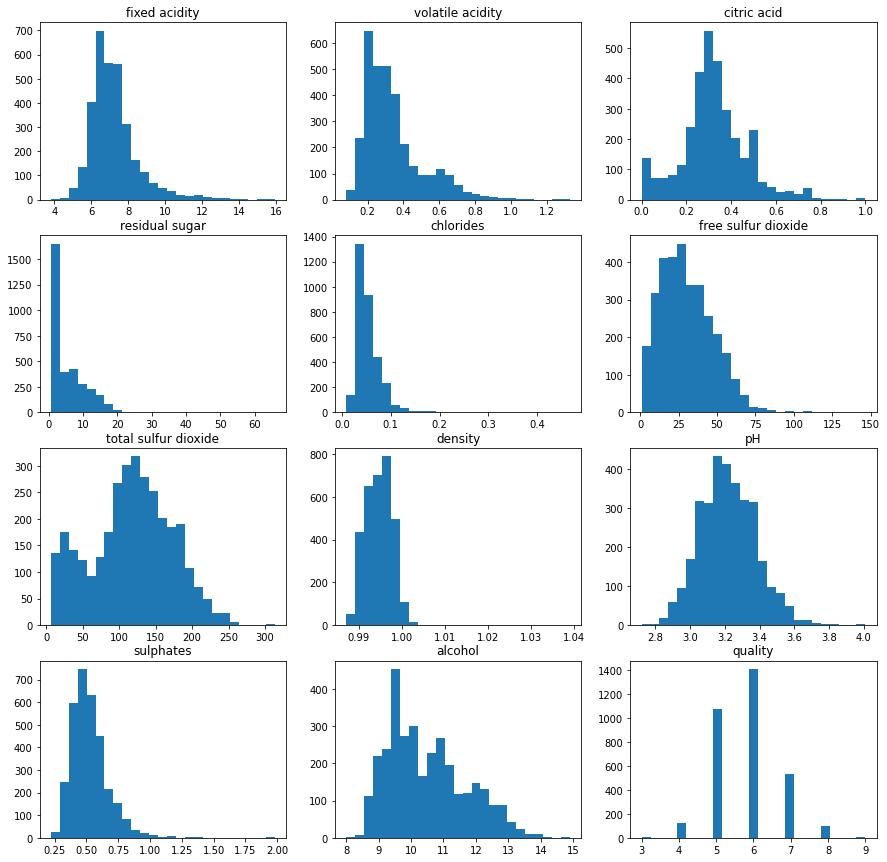

In [10]:
fig, axs = plt.subplots(4, 3)
fig.set_figheight(15)
fig.set_figwidth(15)

k = 0

for i in range(0,4):
    for j in range(0,3):
        col = df.columns[k]
        axs[i,j].hist(df[col], bins = 25)
        axs[i,j].set_title(col)
        k = k+1     

We can break these histograms down further by looking at the distributions of red and white wines separately for each column:

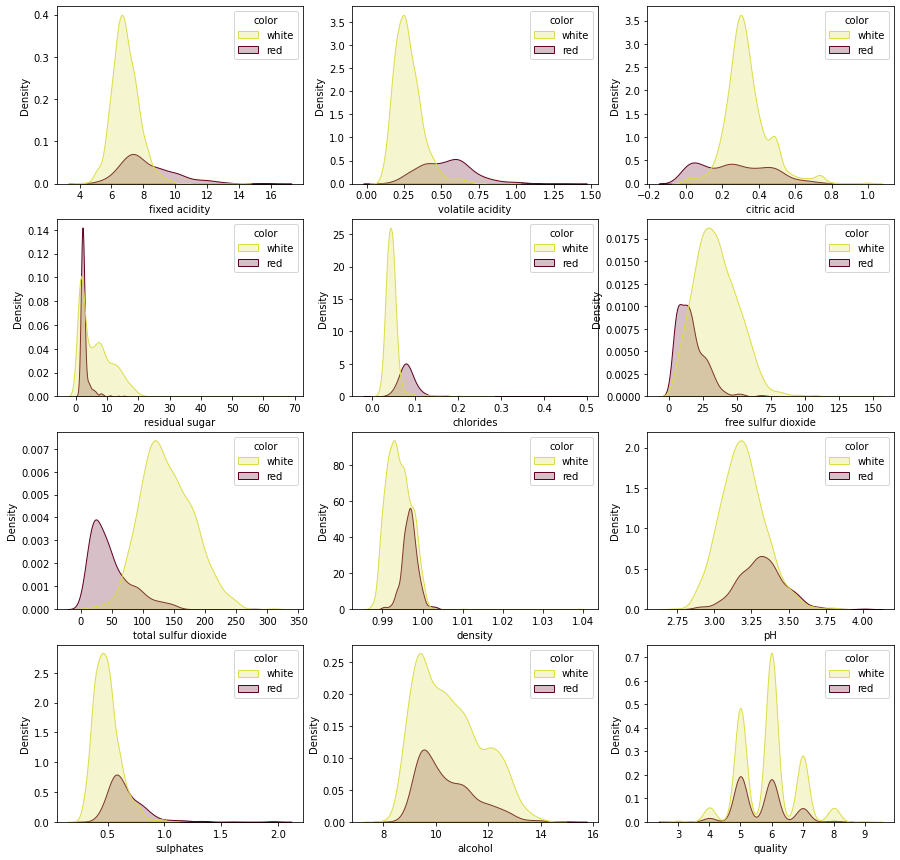

In [11]:
wine_colors = ['#dbdd46','#5F021F']
sns.set_palette(sns.color_palette(wine_colors))

fig, axs = plt.subplots(4, 3)
fig.set_figheight(15)
fig.set_figwidth(15)

k = 0

for i in range(0,4):
    for j in range(0,3):
        col = df.columns[k]
        sns.kdeplot(df[col], hue = df['color'], shade = True, ax = axs[i,j])
        k = k+1     

Looks like many of these columns follow normal or [exponential distributions](https://en.wikipedia.org/wiki/Exponential_distribution).

The distributions of residual sugar and free sulfur dioxide between red and white wines appear to be very different. These could be a good features to include in our classification model!

Let's now look at the relationships between variables with a correlation plot:

In [12]:
corr = df.corr()

In [13]:
mask = np.triu(np.ones_like(corr, dtype=bool))

<AxesSubplot:>

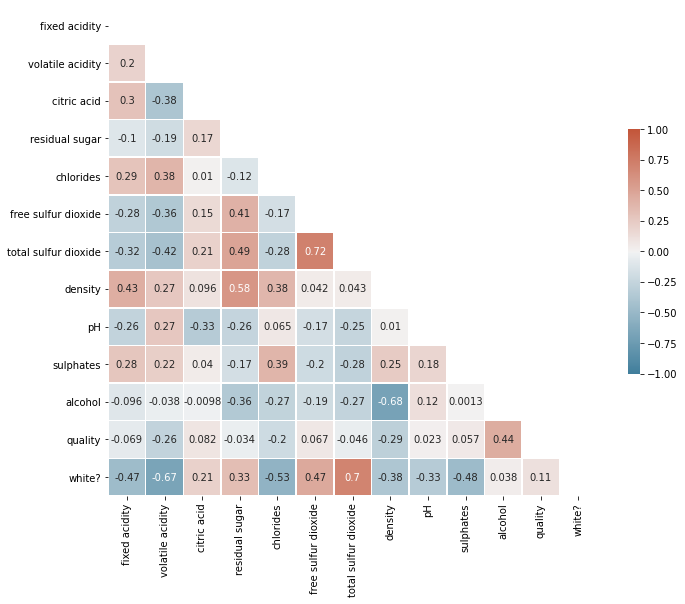

In [14]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin = -1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

Looking at the bottom row, we can see which variables are storngly correlated with white wines vs. reds.

* Positive correlation with white (have a red-shaded cell):
  * Citric acid
  * Residual sugar
  * Sulfur dioxide
* Negative correlation with white (have a blue-shaded cell):
  * Acidity
  * Chlorides
  * Density
  * pH
  * Sulfates
  
There are also some strong relationships between predictor variables, indicated by the magnitude of the correlation coefficient:
 * Alcohol and quality (go figure)
 * Alcohol and density
 * Density and residual sugar
 * Density and fixed acidity
 * Free and total sulfur dioxide
 * Volatile acidity and citric acid

We can look at the relationships and distrubtions between multiple variables using a 2D kernel density plot! Each axis represents a distribution of a variable, and the contours represent the shape of a distribution. You can think of these like the contour maps you see plotting elevation vs. longitude and latitude. The peaks of the mountain tops on a map like that are analogous to the peak (or mode) of a distribution of data.

<img src = 'images/contour_plot.png'>

Basically, we are comparing two distributions of data (white wines and red wines) on 2 axes instead of 1.

<AxesSubplot:xlabel='alcohol', ylabel='density'>

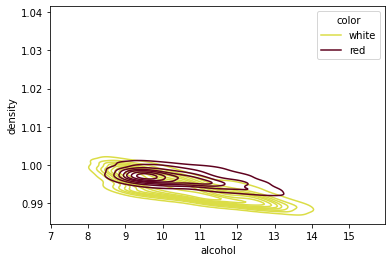

In [15]:
sns.kdeplot(x = df['alcohol'], y= df['density'], hue = df['color'], color =  wine_colors)

Red wines have slightly higher density for the given level of alcohol than white wines.

<AxesSubplot:xlabel='density', ylabel='residual sugar'>

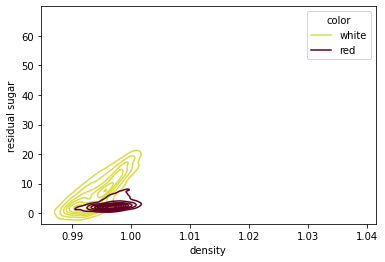

In [16]:
sns.kdeplot(x = df['density'], y= df['residual sugar'], hue = df['color'])

White wines have much more variability with residual sugars than reds, and these tend to lead to higher density levels in white wines while having very little effect on red wines.

<AxesSubplot:xlabel='density', ylabel='fixed acidity'>

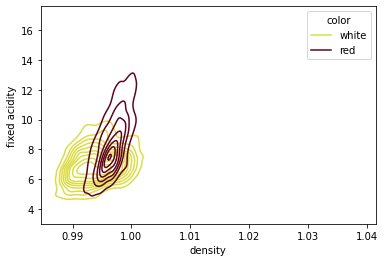

In [17]:
sns.kdeplot(x = df['density'], y= df['fixed acidity'], hue = df['color'])

Red wines have much more variability in fixed acidity, while white wines have more variability in density.

<AxesSubplot:xlabel='free sulfur dioxide', ylabel='total sulfur dioxide'>

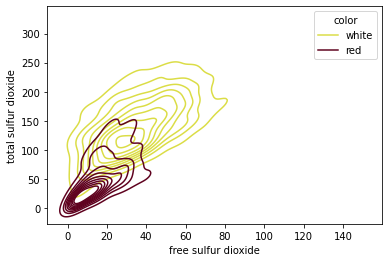

In [18]:
sns.kdeplot(x = df['free sulfur dioxide'], y= df['total sulfur dioxide'], hue = df['color'])

Free sulfur dioxide and total sulfur dioxide are highly correlated in both kinds of wine, and white wines typically have higher sulfur dioxide levels than red wines.

<AxesSubplot:xlabel='volatile acidity', ylabel='citric acid'>

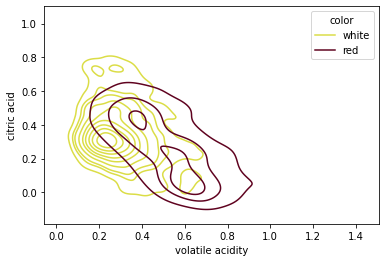

In [19]:
sns.kdeplot(x = df['volatile acidity'], y= df['citric acid'], hue = df['color'])

Red wines tend to have higher volatile acidity than white wines, but both seem to have similar levels of citric acid.

## Split data into training and validation sets

Now we need to split our dataset in to a training set and a validation set. In this case, we are using 80% of the rows of our training data to fit our model and using the remaining 20% to validation our results. 

You might be wondering why we dont use all of our training data to fit our model. The reason is that we want to avoid **overfitting** our model to our training data. When we overfit our model to our training data, our model tends to perform poorly on new, unseen data because our model will effectively be memorizing our training data.

There's an inherent tradeoff in splitting our data between our training set and our validation set. By giving our model more data in the training set, we will be able to come up with better model parameters for our model. But leaving more data for the validation set will allow us to more accurately estimate the model's performance on unseen data. Hence there's a natural tradeoff between estimating model parameters (e.g. regression coefficients) and estimating our model's performance (e.g. model accuracy on unseen data). We want to find the right balance between estimating model parameters and estimating model performance.

A typical rule of thumb is to reserve 20% of your data for your validation set. Depending on your data, you might find that you need more rows in your validation set (especially if your overall dataset doesn't have many rows).

In [20]:
#Data was already shuffled before it was loaded, but typically you want to have shuffle = True
#I used shuffle = False here to make merging datasets easier later in the code

train_df, validation_df = train_test_split(df, test_size = 0.2, random_state = 37, shuffle = False)

In [21]:
#Define the features we want to use in our model
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality']

**TL;DR: Split your training data into a training set and validation set to accurately estimate model parameters (training) as well as model performance (validation).**

## Standardize our Continuous Variables

Our next step is to **standardize** our data across different columns. This will allow our different features to have a similar range of values, which will help us with some of the models we'll be working with.

For example, notice how the range of values between `Fixed Acidity` and `Volatile Acidity` are very different:

In [22]:
print("Range of values for Fixed Acidity: " + str(train_df['fixed acidity'].max() - train_df['fixed acidity'].min()))
print("Range of values for Volatile Acidity: " + str(train_df['volatile acidity'].max() - train_df['volatile acidity'].min()))

Range of values for Fixed Acidity: 12.100000000000001
Range of values for Volatile Acidity: 1.25


Notice that the range of values for Fixed Acidity are an order of magnitude higher than Volatile Acidity. We want our different columns to have similar ranges of values so we can apply **regularization** techniques to these columns. We can do this by calculating the mean and the standard deviation of each column, and performing the following calculation on on our data. 

standardized value $ = \frac{x - \mu}{\sigma} $

where:
 - $x$ is a data point in a given column
 - $\mu$ is the column's mean value
 - $\sigma$ is the column's standard deviation

This will ensure that the data between columns will have similar ranges of values.

What is regularization and why does it matter to us? Regularization is simply a way of preventing overfitting in our model by penalizing our model for *unnecessary complexity*. You can think of regularization like [Occam's Razor](https://en.wikipedia.org/wiki/Occam%27s_razor), where we want the simplest possible explanation to our problem but cutting out all the noise. 

Below we are going to scale all of our continuous data, as listed in `continuous_cols`.

In [23]:
continuous_cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 
                   'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']

In [24]:
non_continuous_cols = ['quality', 'color', 'white?']

In [25]:
scaler = StandardScaler()

In [26]:
#This will calculating the column means and standard deviations for all the data in our training dataset.
scaler.fit(train_df[continuous_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [27]:
#This will scale the data in our training dataset (subtract the mean and divide by the standard deviation)
scaled_continuous_train_df = pd.DataFrame(scaler.transform(train_df[continuous_cols]), columns = continuous_cols)

In [28]:
#Now we merge our scaled data back with on non-continuous data into one dataframe using the merge function
scaled_train_df = pd.merge(scaled_continuous_train_df, train_df[non_continuous_cols], left_index = True, right_index = True)
scaled_train_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,white?
0,-0.393629,1.837598,-0.128667,-0.883377,-0.793272,-0.733554,-0.730756,-1.801979,-0.371852,0.479796,2.038350,4,white,1
1,-0.859142,1.593129,-2.196297,-0.862774,-0.413355,-0.382835,-0.676845,-0.334390,0.552266,-1.018091,-0.906175,4,white,1
2,1.701179,-1.034914,1.594358,-0.800964,-0.191737,-0.967366,-0.407292,0.056968,-1.234361,0.547882,-0.149011,6,white,1
3,-0.471215,-0.118155,-0.680035,2.310148,-0.286716,0.435508,0.293546,1.035361,-0.002205,0.956397,-0.064882,6,white,1
4,1.468422,-0.362624,1.180832,-0.718550,0.124860,-1.201179,-0.083829,0.350485,-0.433459,-0.473404,-0.317270,5,white,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,-0.626386,-1.157148,0.284859,-0.759757,-0.666633,0.727774,0.599039,-0.823586,1.229952,1.092568,0.439893,8,white,1
2595,-0.626386,-1.279383,1.042990,-0.800964,1.169631,0.552414,0.742801,-0.627908,-0.063812,-1.154262,-0.569658,6,white,1
2596,-0.548800,-1.157148,1.594358,0.084982,-0.318376,2.598273,0.814681,0.030877,-1.542400,-0.881919,-0.990304,5,white,1
2597,0.071884,0.309666,-0.059746,-0.636137,0.599756,-1.259632,-1.269862,0.480938,1.168344,0.071282,-0.906175,6,red,0


In [29]:
#We repeat this process for our validation set
scaled_continuous_validation_df = pd.DataFrame(scaler.transform(validation_df[continuous_cols]), columns = continuous_cols)

In [30]:
scaled_continuous_validation_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.149469,-0.484858,0.767306,0.105585,-1.046549,-0.499741,0.149784,-0.627908,-0.556675,0.139368,0.860540
1,-0.471215,-0.607093,-0.680035,1.403599,-0.128417,0.260149,0.527158,0.663571,-0.741499,0.956397,-0.906175
2,0.459811,-0.423741,1.801121,1.176962,-0.603313,0.786227,0.796711,0.970134,-0.987930,-0.813833,-1.326821
3,0.614982,-0.729327,0.698385,1.877477,-0.350035,0.844680,0.832652,1.818075,-0.063812,1.092568,-1.579209
4,0.382226,0.065197,0.974069,1.300582,1.042992,1.779930,1.192056,1.022315,-2.220087,-0.405319,-1.242692
...,...,...,...,...,...,...,...,...,...,...,...
645,-0.083287,-0.973796,-0.404351,-0.862774,-0.445015,-0.616648,-0.820607,-0.693134,-1.111146,1.432997,-0.485528
646,0.847739,-0.668210,0.767306,-0.471310,-0.634973,-0.967366,-0.281501,-0.627908,-0.433459,-1.154262,0.860540
647,1.546008,-0.362624,0.974069,-0.471310,0.093201,0.493961,0.293546,0.415712,-0.495067,0.343625,-0.822046
648,-0.471215,-0.607093,-0.266509,-0.759757,-0.856591,0.493961,0.275575,-0.947516,0.737090,-0.473404,0.776411


In [31]:
#Now we merge our scaled data back with on non-continuous data into one dataframe using the merge function
scaled_validation_df = pd.merge(scaled_continuous_validation_df, validation_df[non_continuous_cols].reset_index(), left_index = True, right_index = True)
scaled_validation_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,index,quality,color,white?
0,0.149469,-0.484858,0.767306,0.105585,-1.046549,-0.499741,0.149784,-0.627908,-0.556675,0.139368,0.860540,2599,6,white,1
1,-0.471215,-0.607093,-0.680035,1.403599,-0.128417,0.260149,0.527158,0.663571,-0.741499,0.956397,-0.906175,2600,5,white,1
2,0.459811,-0.423741,1.801121,1.176962,-0.603313,0.786227,0.796711,0.970134,-0.987930,-0.813833,-1.326821,2601,6,white,1
3,0.614982,-0.729327,0.698385,1.877477,-0.350035,0.844680,0.832652,1.818075,-0.063812,1.092568,-1.579209,2602,7,white,1
4,0.382226,0.065197,0.974069,1.300582,1.042992,1.779930,1.192056,1.022315,-2.220087,-0.405319,-1.242692,2603,5,white,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,-0.083287,-0.973796,-0.404351,-0.862774,-0.445015,-0.616648,-0.820607,-0.693134,-1.111146,1.432997,-0.485528,3244,6,white,1
646,0.847739,-0.668210,0.767306,-0.471310,-0.634973,-0.967366,-0.281501,-0.627908,-0.433459,-1.154262,0.860540,3245,5,white,1
647,1.546008,-0.362624,0.974069,-0.471310,0.093201,0.493961,0.293546,0.415712,-0.495067,0.343625,-0.822046,3246,5,white,1
648,-0.471215,-0.607093,-0.266509,-0.759757,-0.856591,0.493961,0.275575,-0.947516,0.737090,-0.473404,0.776411,3247,5,white,1


Now that we've scaled our training and validation data, we can see that the ranges of our columns are more or less equivalent:

In [32]:
print("Range of values for Fixed Acidity: " + str(scaled_train_df['fixed acidity'].max() - scaled_train_df['fixed acidity'].min()))
print("Range of values for Volatile Acidity: " + str(scaled_train_df['volatile acidity'].max() - scaled_train_df['volatile acidity'].min()))

Range of values for Fixed Acidity: 9.387842982052408
Range of values for Volatile Acidity: 7.639659615541736


We'll now split our scaled data into our features / input variables (denoted by X) and our response / output variable (denoted by y).

In [33]:
X_train = scaled_train_df[features]
y_train = scaled_train_df['white?']

In [34]:
X_validation = scaled_validation_df[features]
y_validation = scaled_validation_df['white?']

**TL;DR: Standardizing your data can help with some regularization techniques**

## Model Assessment - Metrics

Now that we have our data transformed into a format to start building models, we need to start thinking about how we should assess the performance of our models. 

With classification problems like this, there are a number of metrics we can use to assess model performance. We'll start with some classic metrics that come from the aptly named **Confusion Matrix**:

<img src = 'images/confusionMatrix.png'>

Image Source: https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

The confusion matrix is a 2x2 framework (MBB consultants please contain your excitement) for assessing the types of errors that occur in classification problems. On the x-axis you have the actual values of the thing you are trying to classify (is the wine red or white in reality?) and on the y-axis you have your model's predictions (is the wine red or white according to our model's predictions?). You also have the notion of *positive* and *negative* which depends on how your dataset is defined. In our example, a positive (or a value of 1) means that the wine is white, and a negative means the wine is red. It's important to make sure you understand what a positive value versus a negative value is in your data when doing these kinds of classification problems so you can correctly interpret the results!

Next we have **true positives** and **false positives**. A true positive (AKA **TP**) is when your model predicts the wine as being white (positive) and the wine in reality is actually white. A false positive (AKA **FP**) is when your model predicts the wine as being white (positive) when in reality the wine is red (negative). 

Conversely, we have **true negatives** and **false negatives**. A true negative (AKA **TN**) is when your model predicts the wine as a red (negative) and the wine is actually red in reality (negative). A false negative (AKA **FN**) is when your model predicts the wine as red (negative) when in reality the wine is white (positive).

This is intuitive image that shows the differences between TPs, FPs, TNs, and FNs, where a positive value indicates the person is pregnant:

<img src = 'images/confusionMatrix2.png'>

Image source: https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

Given these definitions, we can start to define some metrics to assess model accuracy. 3 of the most common metrics that come from the confusion matrix are **accuracy**, **precision**, and **recall**.

Accuracy is simply measure of the proportion of objects you classified correctly (TPs and TNs) over all objects in your dataset. In other words, accuracy means "what percentage of objects did your model classify correctly?"

Precision measures the proportion of objects your model correctly classified as positive (TPs) over the total number of objects your model classified as positive (TPs and FPs). In other words, precision means "what percentage of your model's predictions that are positive are actually positive?" Precision is a great metric to use when the cost of making a false positive is relatively high, like with email spam classification. Assuming that a positive classification indicates that the email is spam, a false positive would mean that our spam detector would think that the email is spam when in reality it is "ham", or something we would want to read. Thus, having high precision would be very important to us in this kind of classification problem.

Recall measures the proporition of objects your model correctly classifies as positive (TPs) over the total number of objects that are actually positive (TPs and FNs). In other words, recall means "what proportion of positive values (i.e. white wines) did my model correctly classify?" Recall is a great metric when the cost of a false negative is really high. For example, think of medical diagnosis tests like detecting cancer in patients. We would want a model with high recall, one that catches as many patients with cancer as possible so they could get treatment. A false negative would mean that person would be left untreated, so we would want to minimize that value as much as possible.

Here's another good visualization depicting the differences between precision and recall:

<img src = 'images/precision_recall.png'>

Image source: https://towardsdatascience.com/whats-the-deal-with-accuracy-precision-recall-and-f1-f5d8b4db1021

Let's start using these three metrics in our upcoming models!

We'll start by generating a baseline to compare our future models against. Since about 75% of our training data is white wine and the rest of reds, a naive classifier would simply always predict that a wine is white since this would guarantee about 75% accuracy:

In [35]:
naive_class_forecast = np.repeat(1, validation_df.shape[0])

In [36]:
accuracy_score(y_true = y_validation, y_pred = naive_class_forecast)

0.7738461538461539

In [37]:
precision_score(y_true = y_validation, y_pred = naive_class_forecast)

0.7738461538461539

In [38]:
recall_score(y_true = y_validation, y_pred = naive_class_forecast)

1.0

F1 score is a combination of precision and recall according to the following formula:

$ F_1 = 2 \frac{precision \times recall}{precision + recall}$

F1 is a harmonic mean of precision and recall, which will balance the two scores together. F1 is often favored over accuracy when the costs of False Positives and False Negatives are both very high and/or when there is an imbalance in the classes we are trying to classify (e.g. our training set is mostly white wines).

In [39]:
f1_score(y_true = y_validation, y_pred = naive_class_forecast)

0.8725065047701648

Let's talk about one more metric for classification methods: **log-loss**. To understand this metric, we should now switch our thinking about what exactly our models will be predicting. Before, with the confusion matrix paradigm, our models were making **hard classifications**: predicting a given wine is 100% a white or this wine is 100% a red. Our models can also make predictions on the *probability* that a wine is white. More certain classifications that a wine is white [or red] will be very close to 1 [or 0], while uncertain classificaitons that a wine is white [or red] will be close to 0.5. 

Log-loss is a metric that's very useful in classification problems when we are predicting probabilities rather than hard classifications. While the background on log-loss is more complicated and outside the scope of this notebook, *our goal is to minimize a model's log-loss*.

#### Math (feel free to skip)

$log loss = -\frac{1}{N} \sum_{i=1}^{N} y_i log(\hat{y_i}) + (1- y_i) log(1 - \hat{y_i} ) $

where:
 - $y_i$ is the actual value (1 = white, 0 = red)
 - $\hat{y_i}$ is the predicted probabilty from your model (between 0 and 1)
 
Note that when your model makes a confident prediction that is true (model predicts 0.99 white and the wine is white), that log-loss is very small for that prediction:

$ -[\boldsymbol{1 * log(0.99)} + (1 - 1) log(1 - 0.99)]= -[-0.01 + 0] = \boldsymbol{0.01} $

But when your model makes a confience prediction that is wrong (model predicts 0.99 white and the wine is red), then the log-loss is massive!

$ -[0 * log(0.99) + \boldsymbol{(1 - 0) log(1 - 0.99)}] = -[0 + -4.61] = \boldsymbol{4.61} $

**Note**: I've bolded the parts of the equation where the values don't cancel to zero to highlight the impact that a predicted probability has on the log-loss calculation.

#### End of optional math

A naive forecast in this case will simply predict the prior probability of a wine being white based upon the training set. So in this case, our naive forecast will predict a probability of being a white wine consistently at 0.75.

In [40]:
naive_prob_forecast = np.repeat(np.mean(df['white?']), validation_df.shape[0])
naive_prob_forecast[:10] #show the first 10 predictions in our naive forecast, all being 0.76

array([0.76023392, 0.76023392, 0.76023392, 0.76023392, 0.76023392,
       0.76023392, 0.76023392, 0.76023392, 0.76023392, 0.76023392])

In [41]:
log_loss(y_true = y_validation, y_pred = naive_prob_forecast)

0.5351021374492888

**TL;DR: Pick the classification metric that best suits the kind of problem you're trying to solve**

# Classification Techniques

## Support Vector Machines (SVM)

To kick things off in Sommelier tier, let's take a look at Support Vector Machines (SVMs). This type of model was very popular in the 1990s because of its ability to hand non-linearity in classification:

<img src = 'images/svm_separability.png'>

SVMs are able to hand non-linearly separable classes as seen in example B above in which normal classification models that produce linear decision boundaries, like LDA, tend to underfit. SVMs handle non-linearly separable classes by using something called the kernel trick, which maps our data to a higher dimensional space and allows us to better separate our data. Below is a good visual representation of what's happening with SVM:

<img src = 'images/kernel_trick.png'>

Image source: https://medium.com/@zxr.nju/what-is-the-kernel-trick-why-is-it-important-98a98db0961d

By transforming our data into a higher dimension space (from 2D to 3D in the above example), we have now fit a linear decision surface (a 2D plane) that divides the two classes in 3D space. Often times our data will not be easily separable by a straight line, so techniques like this will help us better divide our different classes of data (white wines and red wines).

On top of the kernel trick, the main goal of SVM is to draw a boundary between classes of data and *maximize the margin* between classes. What does this mean? Take a look at the picture below:

<img src = "images/svm_multiple_boundaries.JPG">

Image source: *Introduction to Statistical Learning* - G. James et. al., Page 340

What this picture is depicting is that there are numerous (in fact, infinite) number of lines that can be drawn that can perfectly separate the red dots from the blue dots. With so many options of lines to draw, how can we pick the best possible line? This is where margin maximization comes in:

<img src = "images/margin_maximization.JPG">

Image source: *Introduction to Statistical Learning* - G. James et. al., Page 342

We select the line that maximizes the distance between the points that are nearest to the decision boundary and to the decision boundary itself. The above picture shows 3 points that are all equally far from the decision boundary, which we call *support vectors*. In fact, the shape of this line is only influenced by these 3 support vectors. If we were to slightly move these points, the shape of our line would change. But if we slightly changed any of the other data points, our line would not change. Hence, the support vectors are *supporting the shape of our decision boundary*.

There's a lot more to SVMs than this, but this is a good starting point for us.

**TL;DR: SVMs help us deal with non-linearity in our data**

In [42]:
#Feel free to add or remove any variables here if you think it will help the model classify between red and white wines!
model_features = ['residual sugar','free sulfur dioxide']

model_train = X_train[model_features]
model_validation = X_validation[model_features]

SVM also has a complexity parameter to prevent overfitting! It's called `C`, and we can think of C as how tolerant we are of observations falling on the wrong side of the decision boundary in our training set. Setting a really low value of C will be we are extremely intolerant of this happening, which will lead to overfitting in our training data. Setting a high value of C will probably be too lax and will result in underfitting our data.

In [43]:
C = np.linspace(0.5, 1.5, 11)
C

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5])

In [44]:
SVM = GridSearchCV(SVC(gamma = 'auto', probability = True, random_state=37),
                           param_grid={'C':C},
                           cv=10)

In [45]:
SVM.fit(model_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=True, random_state=37, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [46]:
SVM.best_params_ #The best value for C after cross validation

{'C': 1.4}

Now let's make predictions with our fit SVM model:

In [47]:
SVM_pred_class = SVM.predict(model_validation)

In [48]:
print("Model accuracy with SVM: " + str(accuracy_score(y_true= y_validation, y_pred = SVM_pred_class)))
print("Model f1 score with SVM: " + str(f1_score(y_true= y_validation, y_pred = SVM_pred_class)))

Model accuracy with SVM: 0.8707692307692307
Model f1 score with SVM: 0.9186046511627908


In [49]:
SVM_pred_prob = SVM.predict_proba(model_validation)

In [50]:
print("Model log-loss with SVM: " + str(log_loss(y_true= y_validation, y_pred = SVM_pred_prob)))

Model log-loss with SVM: 0.3208214692258951


## Random Forest (Decision Trees)

Next up we have a throwback to Q1 DA with decision trees. Decision trees serve as a very easy to interpret and powerful framework for both classification and regression problems. They work by starting at the top of the tree (also called the "root" of the tree) and follow different splits down the tree until you reach one of the end nodes on the tree (also called "leaves").

Here's an example of a **single decision tree** used in our problem of classifying red and white wines:

In [51]:
#Feel free to add or remove any variables here if you think it will help the model classify between red and white wines!
model_features = ['residual sugar','free sulfur dioxide']

model_train = X_train[model_features]
model_validation = X_validation[model_features]

In [52]:
DT = DecisionTreeClassifier(random_state = 37, max_depth = 2)

In [53]:
DT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=37, splitter='best')

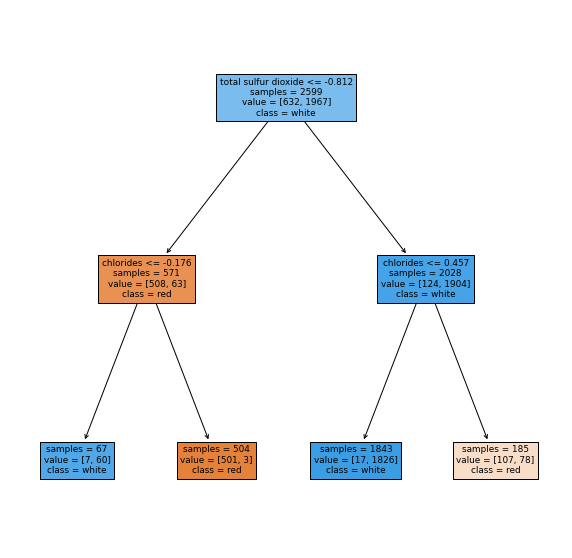

In [58]:
plt.figure(figsize=(10,10))

_ = plot_tree(DT, 
          feature_names = features,
          class_names = list(set(train_df['color'].values)),
          impurity = False,
          filled = True)

The above is an example of a very simple decision tree. To understand what the tree is showing, let's break down each node line by line.

The first line (except for the leaves) shows the decision rule for that node. Looking at the top node, the first decision rule in the classifier is checking the value of `free sulfur dioxide`. If the standardized value for free sulfur dioxide is less than -0.704, it will follow the left branch. If it is greater than -0.704, it will follow the right branch. The next level. This holds true for the second level as well, where both nodes are looking at `residual sugar` to make further classifications.

The second line shows the number of samples that enter that node from the training set. Notice that there are 2599 samples in the top node, same as the number of samples in our training set.

The third line shows the number of [red, white] wines (in that order) within that sample. So we have 632 red wines and 1967 white wines entering the decision tree.

The last line shows the majority class of that node, which is especially useful for the leaf nodes. We can see the 1st, 3rd, and 4th nodes will predict "white" for the wine color and that the 2nd node will predict "red".

### Pros/Cons of Decision Trees

Decision trees can be very powerful for classification due to their flexible nature, interpretability, and ability to capture [interaction terms](https://statisticsbyjim.com/regression/interaction-effects/) very easily. However, there are a number of drawbacks to building a single decision tree:

1) Because they are constructed in a greedy manner (pick the feature that separates the data the best at the top of the tree), it can lead to high variability in the results if that top feature (e.g. free sulfur dioxide) is swapped for another (e.g. alcohol) and has cascading effects on the rest of the tree.

2) Decision tree's flexible nature can easily overfit by making the tree structure too deep. You can regularize the trees by limiting their depth and requiring a minimum number of samples to split the data upon, but we'll find there are better ways to do this

**TL;DR: Decision trees are flexible, but can easily overfit**

### Random Forest (many Decision Trees)

To overcome the drawbacks of overfitting instability of trees, the idea of building many decision trees and **ensembling** them together came about. Ensembling is simply when you take multiple models and average their predictions together to come up with a new prediction. 

<img src = "images/ensemble.png">

Image source: https://www.researchgate.net/publication/293194221_Heterogeneous_versus_Homogeneous_Machine_Learning_Ensembles

The idea stems from *wisdom of the crowds*, where typically the best results come from drawing upon the collective wisdom of many individuals rather than relying upon a single expert. One example of the wisdom of the crowds prevailing is in a Darden classroom setting where you rely upon diverse experiences of your classmates to provide better outcomes for your learning. The exception might be Accounting, where you need to rely on the token CPA in your class to carry you through core, mimicking the "chase the expert" philosophy.

A framework for understanding where wisdom of the crowds might prevail over chase the expert is another 2x2 matrix (McKinsey consultants rejoice!):

<img src = "images/woc_vs_cte.JPG">

On the x-axis, diversity refers to how similar/different the errors are between estimators. With highly correlated errors, everyone will tend to overestimate something together (e.g. the stock price of Gamestop next week) or everyone will tend to underestimate something together. With uncorrelated errors, you will have a pretty even mix of people overestimating and underestimating something. Highly correlated errors will lead to lower diversity and uncorrelated errors lead to higher diversity.

On the y-axis, difference in expertise refers to the range of performance between the top estimators and the "average joes" (e.g. hedge fund managers vs. your brother on r/WSB). This can be measured by the variation in the errors made by all predictors. 

Now that we know that a wisdom of the crowd approach is useful in building models, let's take a look at how we can build many decision trees to achieve higher prediction accuracy.

### Building Diverse Decision Trees with Bagging

To build diverse trees, we will need to design a process that will ensure that our trees make diverse predictions. How can we promote diversity when all of our trees will see the same data? We can get around this with the concept of **bagging**, which will allow us to build our individual trees off of slightly different datasets, which will produce trees that yield diverse predictions.

Bagging is a combination of **bootstrapping** and **aggregating**:

#### Bootstrapping

Bootstrapping is a sampling technique where we will sample our data *with replacement*. In other words, we will draw N samples from our dataset, but when we draw a sample we will put it back in our dataset where it could be randomly sampled again. That means that the same observation (a wine in our case) could appear in our bootstrapped sample multiple times! See below for an example of 

<img src = "images/sample_w_replacement.png">

Image source: https://www.spss-tutorials.com/simple-random-sampling-what-is-it/

#### Aggregating

With bagging, the idea is that we fit individual decision trees to different bootstrapped datasets. Since every bootstrapped dataset is slightly different due to the random nature of sampling, we should expect that each tree should make slightly different predictions from one another. After we've trained a "forest" of these trees, we want to *aggregate* their predictions together into an ensemble of predictions.

<img src = "images/bagged_ensemble.jpg">

Image source: https://www.kdnuggets.com/2019/09/ensemble-learning.html

Let's create a couple of decision trees to illustrate this point of bootstrapping and aggregating in our data.

We'll start by build 50 decision trees off of 50 bootstrapped data samples. Feel free to skip over this code, I will walk through the main parts below

In [61]:
number_of_trees = 50 #This is the number of trees we want in our forest
random_forest = []   #This will store all of our models in a list
bootstrapped_samples = [] #This will store all of our bootstrapped samples in a list

#This will create a dataframe for each of our trees predictions on the validation set
rf_predictions = np.empty([number_of_trees,y_validation.shape[0]]) 

#Each iteration of this loop will create a bootstrapped sample, train a decision tree, and generate predictions on the validation set
for tree in range(number_of_trees):
    
    #Generate the bootstrapped dataset
    bootstrap_sample = pd.merge(X_train, y_train, left_index = True, right_index = True).sample(n = 2500, replace = True, random_state = 37+tree)
    model_train_sample = bootstrap_sample[features]
    y_train_sample = bootstrap_sample['white?']
    bootstrapped_samples.append(bootstrap_sample)
    
    #Define and train a new decision tree on our bootstrapped sample
    DT = DecisionTreeClassifier(random_state = 37+tree, max_depth = 2, splitter = 'random')
    DT.fit(model_train_sample, y_train_sample)
    
    #Once trained, add the new tree to the forest
    random_forest.append(DT)
    
    #Generate predictions on validation set
    dt_prediction = DT.predict(X_validation)
    
    #Store predictions in a list
    rf_predictions[tree,:] = dt_prediction


Let's take a look at our bootstrapped samples. Here's the first bootstrapped sample:

In [62]:
bootstrapped_samples[0].head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,white?
1935,-0.393629,-1.157148,0.009175,0.497050,-0.666633,-0.792007,-0.640905,0.128716,0.429050,-1.494691,-0.401399,6,1
363,0.071884,-0.057037,0.560543,0.280714,-0.539994,0.084790,0.383397,-0.888812,-1.172753,-1.562777,1.197057,7,1
844,-0.005702,-0.607093,-0.335430,-0.842171,-0.539994,0.026337,0.095873,-0.660521,-0.433459,-0.473404,-0.149011,6,1
2299,-1.014313,1.654246,-1.644929,-0.697947,0.504777,-0.850460,-1.665206,-0.314822,2.092462,1.637254,0.524023,6,0
988,-0.083287,-0.362624,-0.059746,-0.821567,-0.065098,-0.616648,-0.335411,-1.316044,-0.433459,-0.201061,0.776411,5,1


Here's the second:

In [63]:
bootstrapped_samples[1].head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,white?
53,-0.316044,0.004080,-0.335430,-0.059242,0.156520,-0.967366,0.940473,-0.719224,0.305835,0.275539,0.944669,6,1
1491,-0.238458,0.370784,1.663279,1.176962,-0.381695,0.552414,0.455277,0.904908,-0.495067,-0.473404,-1.495080,5,1
316,-0.005702,-0.545976,-0.886798,0.517653,-0.350035,1.195399,0.994383,0.546164,-0.371852,-0.609576,-1.074433,5,1
1282,-0.703971,0.126315,1.249753,0.579463,-0.065098,1.195399,1.533489,0.252646,-0.125420,-0.132976,-0.737916,6,1
2071,0.382226,0.737487,-0.955719,-0.450706,-0.033438,-0.733554,0.473248,-0.262641,-0.618283,-0.132976,0.271635,6,1


And here's the 50th:

In [64]:
bootstrapped_samples[49].head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,white?
1888,0.537397,-0.545976,-0.197588,-0.038638,-0.761612,0.143243,0.006022,-0.954039,-0.987930,-1.426605,1.112928,7,1
1123,0.227055,-0.607093,-0.197588,-0.903981,-0.286716,0.201696,-0.586994,-1.475848,-1.111146,-0.950005,0.818475,6,1
2075,-0.393629,-0.607093,0.215938,1.568426,-0.160077,1.955289,1.587400,0.741843,-0.433459,-0.201061,-0.822046,5,1
1001,0.382226,-0.423741,0.215938,-0.038638,-0.793272,-0.032117,0.006022,-0.888812,-0.679891,-0.745747,1.449445,6,1
1612,0.071884,-0.484858,1.180832,-0.100448,-0.856591,0.084790,-0.173680,-0.367003,0.121011,0.071282,0.271635,6,1


Now let's plot a few of these trees. Here's Tree #1:

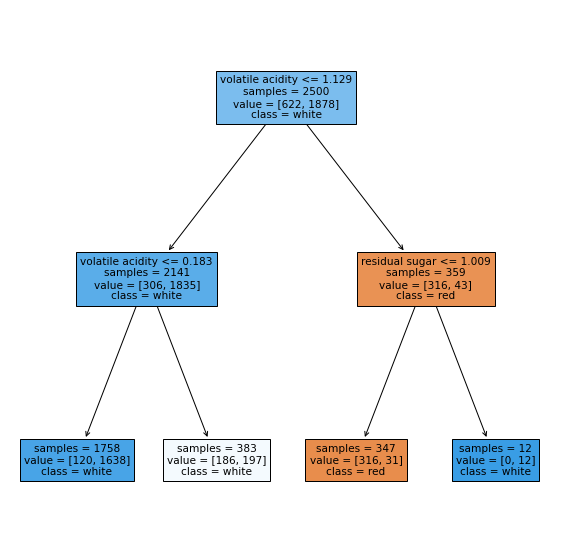

In [65]:
plt.figure(figsize=(10,10))

ax1 = plot_tree(random_forest[0], 
              feature_names = features,
              class_names = list(set(train_df['color'].values)),
              impurity = False,
              filled = True)

Here's Tree #2:

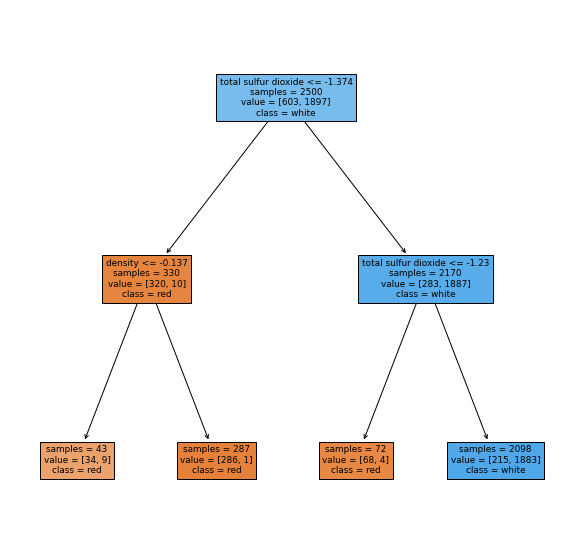

In [66]:
plt.figure(figsize=(10,10))

ax1 = plot_tree(random_forest[1], 
              feature_names = features,
              class_names = list(set(train_df['color'].values)),
              impurity = False,
              filled = True)

And here's our last tree, Tree #50:

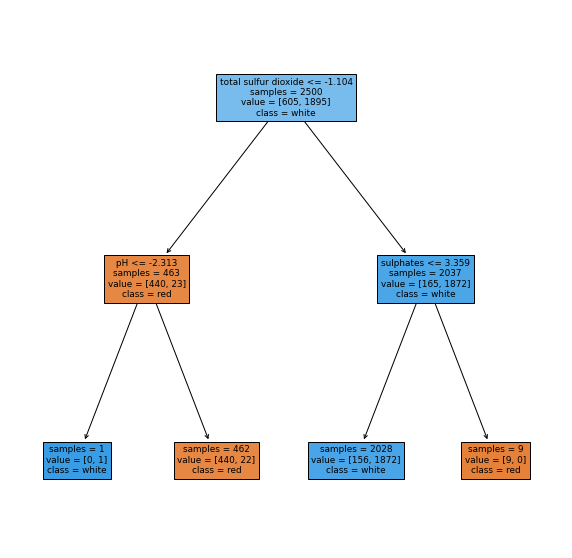

In [67]:
plt.figure(figsize=(10,10))

ax1 = plot_tree(random_forest[49], 
              feature_names = features,
              class_names = list(set(train_df['color'].values)),
              impurity = False,
              filled = True)

Notice that these three trees are very different! Tree 1 only looks at `volatile acidity` and `residual sugar`, Tree 2 looks at `total sulfur dioxide` and `density`, and Tree 50 looks at `sulphates`, `total sulfur dioxide` and `pH`. 

So now we've created diverse trees. We can now aggregate their predictions on the validation set to assess their collective performance. To come up with a single prediction, we can simply do a majority vote between the three trees to establish whether a wine is a red or a white. We do this by taking the average of all 50 trees' predictions:

In [68]:
#Take the average of the predictions across all 50 trees
averaged_predictions = rf_predictions.mean(axis = 0)

averaged_predictions[:20] #The first 20 averaged predictions

array([0.98, 0.98, 1.  , 0.98, 0.98, 0.54, 0.84, 1.  , 0.92, 0.6 , 1.  ,
       0.44, 0.92, 0.96, 1.  , 0.14, 0.96, 0.92, 1.  , 0.94])

In [69]:
emsemble_predictions = (averaged_predictions >= 0.5).astype(int) #Making hard classifications on these predictions with a threshold of >= 0.5
emsemble_predictions[:20] #Show the first 20 hard classifications

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1])

In [70]:
print("Model accuracy of the ensemble: " + str(accuracy_score(y_true = y_validation, y_pred = emsemble_predictions)))

Model accuracy of the ensemble: 0.9661538461538461


That accuracy is pretty good! But how does it compare to our single decision tree from earlier?

In [71]:
DT_predictions = DT.predict(X_validation)

In [72]:
print("Model accuracy of the single decision tree: " + str(accuracy_score(y_true = y_validation, y_pred = DT_predictions)))

Model accuracy of the single decision tree: 0.9246153846153846


Look's like we get a big lift from the wisdom of the crowds approach!

**TL;DR: By creating diverse trees, we can tap into Wisdom of the Crowds and build better models**

### Regularizing Random Forests

Despite the fact that adding many decision trees can reduce overfitting and lead to improved accuracy, we can still overfit with our random forest model. Thankfully, there are a few things we can do to prevent overfitting in our random forest model. Just like how penalized logistic regression have a complexity parameter, random forests also have numerous complexity parameters that help us prevent overfitting:

**Maximum Depth** - The deeper (or "taller") our trees are, the more we reduce our bias (or prevent underfitting our data). This is because we are sub-dividing our data with every split and every level, allowing us to more easily separate our training data. However, when our trees are too deep, we can end up overfitting to our data and not generalizing well to new data. Setting a maximum depth on our trees can prevent overfitting.

**Max features** - When creating diversity in our trees, we often will only select a subset of our features at random to build an individual tree. This helps promote diversity in our ensemble by forcing our trees to not rely so heavily on the most impactful features but instead rely on a combination of weaker features for predictions. By lowering the maximum number of features we will allow a true to use when training, we are limiting its ability to overfit to the data. 

**TL;DR: We can either make our trees shorter or limit the features we allow our trees to use to prevent overfitting**

### Grid Search

So now we have multiple complexity parameters. How can we go about finding which combinations of parameter values work best? One approach is using **grid search**, a technique used to search over a grid of parameter choices to find the best combination on complexity parameters for a given model and dataset.

<img src = "images/grid_search.JPG">

Here we are displaying a grid of our two complexity parameters, maximum depth and maximum features, along with the corresponding model accuracy for each testing value of these parameters. We are testing 3 values for maximum depth (2, 3 and 4) and we are testing 2 values for maximum features (2 and 3). From the above graphic, it looks like our model achieves higher accuracy with higher (less regularized) values for maximum depth and maximum features. However, if make these numbers too large, we could end up overfitting to our training data.

Grid search relies on your best judgement for picking values for your complexity parameters. Adding too many options to your grid will increase training time exponentially, as you will need to try out every combination of parameters. For example, if you try out 10 different values for maximum depth and 7 different values for maximum features, you will end up training 70 random forest ensembles! 

Picking non-sensical choices for the values (e.g. where max features is greater than the number of features in your training set) will also waste time. Grid search is essentially the brute force way of picking which complexity parameters work best for your model and data, so try to be smart about which values you test out.

**TL;DR: We can use brute force to find our optimal complexity parameters.**

Let's try making our own random forest classifier with grid search!

### Random Forest model

In [73]:
#Feel free to add or remove any variables here if you think it will help the model classify between red and white wines!
model_features = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides',
                  'free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality']

model_train = X_train[model_features]
model_validation = X_validation[model_features]

Now we can define our grid. We use a dictionary to specify the name of the complexity parameter as the key, and the values are a list of values that we want to try. So below, we will try values of 2,3 and 4 for maximum depth, and values of 2 and 3 for maximum features. This will lead to 6 different combinations of complexity parameters that we will try on our random forest model.

In [74]:
rf_param_grid = {'max_depth': [2,3,4],
                 'max_features' : [2,3]}

#Calculate the number of values we'll test for each complexity parameter
n_max_depth_params = len(rf_param_grid['max_depth'])
n_max_features_params = len(rf_param_grid['max_features'])

print("Number of model combinations: " + str(n_max_depth_params * n_max_features_params))

Number of model combinations: 6


Now we will use `GridSearchCV` to perform grid search for us. We specify that we want to use a `RandomForestClassifier`, where we will build 5 decision trees (`n_estimators = 5`), and we'll also provide our grid of parameters, `rf_param_grid`, so grid search knows what values to test.

In [75]:
RandomForest = GridSearchCV(RandomForestClassifier(n_estimators = 5, random_state = 37, ),
                           param_grid = rf_param_grid,
                           scoring = 'neg_log_loss',
                           cv = 5)

`%%time` will time how long training takes us. If you add more trees (`n_estimators`) or increase the number of parameters you want to try, this will make the training process take longer.

In [76]:
%%time 
RandomForest.fit(model_train, y_train) #Depends upon your computer's specs, but this shouldn't take more than a couple minutes

Wall time: 459 ms


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=5, n_jobs=None,
                                              oob_score=False, random_state=37,
                                    

We can see which parameters ended up performing best in our model by using the `best_params_` attribute:

In [77]:
RandomForest.best_params_

{'max_depth': 4, 'max_features': 3}

Looks like deeper trees and more features provided better results for us!

Now let's generate predictions on our validation set with our random forest model.

In [78]:
RandomForest_pred_class = RandomForest.predict(model_validation)

In [79]:
print("Model accuracy with random forest: " + str(accuracy_score(y_true= y_validation, y_pred = RandomForest_pred_class)))
print("Model f1 score with random forest: " + str(f1_score(y_true= y_validation, y_pred = RandomForest_pred_class)))

Model accuracy with random forest: 0.9769230769230769
Model f1 score with random forest: 0.985279685966634


In [80]:
RandomForest_pred_prob = RandomForest.predict_proba(model_validation)

In [81]:
print("Model log-loss with random forest: " + str(log_loss(y_true= y_validation, y_pred = RandomForest_pred_prob)))

Model log-loss with random forest: 0.08710407466097754


In [82]:
metrics = {'SVM': 
             {'accuracy':accuracy_score(y_true = y_validation , y_pred = SVM_pred_class),
              'f1_score':f1_score(y_true = y_validation , y_pred = SVM_pred_class),
              'log-loss':log_loss(y_true = y_validation, y_pred = SVM_pred_prob)},
          'Random Forest':
             {'accuracy':accuracy_score(y_true = y_validation , y_pred = RandomForest_pred_class),
              'f1_score':f1_score(y_true = y_validation , y_pred = RandomForest_pred_class),
              'log-loss':log_loss(y_true = y_validation, y_pred = RandomForest_pred_prob)}
                 }

pd.DataFrame(metrics)

,SVM,Random Forest
accuracy,0.870769,0.976923
f1_score,0.918605,0.985280
log-loss,0.320821,0.087104


## XGBoost (Boosting)

For our last model, we will take a look at XGBoost. XGBoost is a very hyped ML algorithm - and with good reason! 

XGBoost is another tree-based model that helps compensate for the shortcomings of a random forest model by reducing bias. Remember that model error is a function of bias, variance, and irreducible error:

$Model Error = Bias^2 + Variance + Irreducible Error$

While random forests did a great job of reducing variance, boosting algorithms do a great job at reducing bias. How does boosting accomplish this? Instead of fitting many independent decision trees in parallel (like random forest), boosting algorithms will fit models *sequentially*. Boosting will iteratively make predictions on a dataset, assess the errors that it made, and then try to correct these errors by either placing more weight on the observations that it misclassified and refitting the next model to that dataset (AdaBoost) or fit the next model to the residuals from the predictions of the previous model (Gradient Boosting). XGBoost is a specific implementation of Gradient Boosting designed to run *extremely* fast. 

Here's a picture highlighting the difference between bagging techniques like random forest and boosting techniques like XGBoost:

<img src = "images/boosting.png">

Image source: https://www.edureka.co/blog/boosting-machine-learning/

Rather than generating multiple, independent models, boosting will iteratively refit to the same data, improving predictive power every time by trying to fit to the errors of the model before it and reduce those errors. 

Let's try generating a small Gradient Boosted tree model to better visualize what's happening here:

In [83]:
#Feel free to add or remove any variables here if you think it will help the model classify between red and white wines!
model_features = ['fixed acidity','volatile acidity','citric acid','residual sugar','pH','sulphates','alcohol','quality']

model_train = X_train[model_features]
model_validation = X_validation[model_features]

We will fit 3 trees sequentially, limit the depth of the trees to just 2 levels

In [84]:
test_XGB = XGBClassifier(n_estimators = 3, max_depth = 2)
test_XGB.fit(model_train, y_train)

[20:41:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cmp2c\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

Let's plot our three trees and see the results:

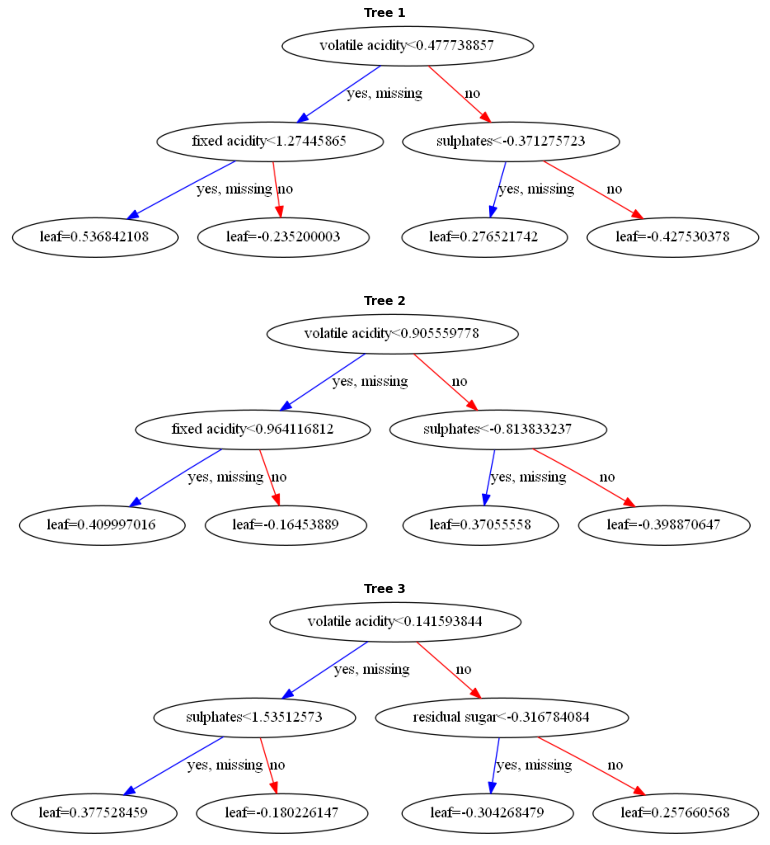

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15,15))
ax1.set_title("Tree 1",fontweight="bold")
ax2.set_title("Tree 2",fontweight="bold")
ax3.set_title("Tree 3",fontweight="bold")

xgb_plot_tree(test_XGB, num_trees = 0, ax = ax1)
xgb_plot_tree(test_XGB, num_trees = 1, ax = ax2)
xgb_plot_tree(test_XGB, num_trees = 2, ax = ax3)

fig = plt.gcf()
plt.show()

So we've fit 3 trees sequentially. Tree 1 is trying to predict whether a wine is white or red (the numbers on the leaves represent "log-odds", which we can convert into probabilities by passin them into the sigmoid function). Tree 2 is trying to predict the *residuals* or errors made by Tree 1 on its predictions, and Tree 3 is trying to predict the residuals from Tree 2 on its predictions. You can imagine that by adding more and more trees in sequence, that we will slowly shrink those residuals down to zero.

To represent this mathematically:
 - $y$ - the true value (is the wine red or white [0 or 1])
 - $\hat{y}_i$ - the prediction of the true value after the $i$th tree in our model (predictions between 0 and 1)
 - $\epsilon_i$ - the true residual from the $i$th tree, or difference between the true value $y$ and our prediction $\hat{y}_i$
 - $\hat{\epsilon}_i$ - the prediction of true residual from the $i$th tree
 
So in Tree 1, we have:

$y = \hat{y}_1 + \epsilon_1$

Tree 1 has generated a prediction, $\hat{y}_1$, for $y$ and there is a remaining residual, $\epsilon_1$. Now we will build a second tree, Tree 2 to try and predict $\epsilon_1$ to correct for that error.

In Tree 2, we have:

$\hat{y}_2 = \hat{y}_1 + \hat{\epsilon}_1$

In the above equation, Tree 2 produces a prediction, $\hat{\epsilon}_1$, for $\epsilon_1$ and adds that to Tree 1's prediction, $\hat{y}_1$, to come up with a new and better prediction, $\hat{y}_2$, for the true value $y$. Still, our 2 Tree model may not perfectly correct for our errors:

$\epsilon_2 = y - \hat{y}_2$
 
The above represents the remaining residual after our prediction from 2 trees. So we repeat the process again by adding a third tree which tries to predict the value of $\epsilon_2$.

In Tree 3, we have:

$\hat{y}_3 = \hat{y}_2 + \hat{\epsilon}_2 $

Like before, we are using the prediction from Tree 2 and adding Tree 3's prediction of the previous residual, $\hat{\epsilon}_2$, to come up with a superior prediction, $\hat{y}_3$, for the true value $y$. Notice that this can also be written by taking the sum of the predictions from each tree in the following way:

$\hat{y}_3 = \hat{y}_1 + \hat{\epsilon}_1 + \hat{\epsilon}_2 $

Where $\hat{y}_1$ is the prediction from Tree 1, $\hat{\epsilon}_1$ is the prediction from Tree 2, and $\hat{\epsilon}_2$ is the prediction from Tree 3. Added all together you get a final prediction $\hat{y}_3$ for the true value $y$. This can continue on for as many estimators as you'd like. 

**TL;DR: By adding more trees, we are correcting errors our earlier trees made.**

That being said, you run the risk of overfitting by adding too many trees to your ensemble. Thankfully, we can regularize our boosting algorithm in a few different ways to prevent overfitting.

### Regularizing XGBoost

So one of the key benefits of boosting is that you greatly reduce the bias of the model by reducing the errors. However, this makes boosting algorithms like XGBoost vulnerable to high variance and overfitting! Thankfully, there are ways to regularize boosting algorithms as well to reduce variance and improve generalizability: **learning rate**, and our previous tree regularization parameters, max depth and max features.

Learning rate (AKA shrinkage parameter) will change the impacts that models fit later in the sequence will have on the final model compared to models earlier in the sequence. Higher learning rates (closer to 1) will lessen the impacts of trees later in the sequence, and typically require fewer trees, while lower learning rates (closer to 1) will heighten the impacts of trees later in the sequence, and typically require more trees to fit. Consider our 3 Tree model from before:

$\hat{y}_3 = \hat{y}_1 + \hat{\epsilon}_1 + \hat{\epsilon}_2 $

To lessen the impact that later trees have on our model and to reduce the chance of overfitting, we introduce the learning rate in the following form:

$\hat{y}_3 = \hat{y}_1 + \alpha \hat{\epsilon}_1 + \alpha^2 \hat{\epsilon}_2 $

where $\alpha$ is the learning rate, a value between 0 and 1

One can quickly see that with larger values of alpha, the predictions from trees further down the line still retain a large impact, but with smaller values of alpha, the predictions from trees further down the line are minimal. Setting a learning rate too low can lead to underfitting while too high a learning rate can lead to overfitting.

Now that we have new ways to regularize our trees, let's try building an XGBoost model!

In [87]:
#Feel free to add or remove any variables here if you think it will help the model classify between red and white wines!
model_features = ['fixed acidity','volatile acidity','citric acid','residual sugar','pH','sulphates','alcohol','quality']

model_train = X_train[model_features]
model_validation = X_validation[model_features]

In [88]:
xgb_param_grid = {'learning_rate': [0.05, 0.1, 0.15],
                  'max_depth': [2,3,4]}

In [89]:
XGB = GridSearchCV(XGBClassifier(n_estimators = 5, random_state=37, eval_metric = 'logloss', n_jobs = num_cpus),
                           param_grid=xgb_param_grid,
                           cv=5)

In [90]:
%%time 
XGB.fit(model_train, y_train)

C:\Users\cmp2c\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Wall time: 783 ms


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_co...
                                     objective='binary:logistic',
                                     random_state=37, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,

In [91]:
XGB.best_params_

{'learning_rate': 0.15, 'max_depth': 4}

Looks like a higher learning rate and deeper trees worked well for us!

In [92]:
XGB_pred_class = XGB.predict(model_validation)

In [93]:
print("XGBoost model accuracy : "+ str(accuracy_score(y_true = y_validation, y_pred = XGB_pred_class)))
print("XGBoost model f1 score: " +str(f1_score(y_true = y_validation, y_pred = XGB_pred_class)))

XGBoost model accuracy : 0.9553846153846154
XGBoost model f1 score: 0.9712586719524281


In [94]:
XGB_pred_prob = XGB.predict_proba(model_validation)

In [95]:
print("XGBoost model log-loss: " +str(log_loss(y_true = y_validation, y_pred = XGB_pred_prob)))

XGBoost model log-loss: 0.34081315031418435


In [96]:
metrics['XGBoost'] = {'accuracy':accuracy_score(y_true = y_validation , y_pred = XGB_pred_class),
              'f1_score':f1_score(y_true = y_validation , y_pred = XGB_pred_class),
              'log-loss':log_loss(y_true = y_validation, y_pred = XGB_pred_prob)
                    }
                 

pd.DataFrame(metrics)

,SVM,Random Forest,XGBoost
accuracy,0.870769,0.976923,0.955385
f1_score,0.918605,0.985280,0.971259
log-loss,0.320821,0.087104,0.340813


# Recap

SVM:
 - Can separate non-linear data very well
 - Tends to overfit to training data and fails to generalize well to unseen data
 - Is computationally expensive with larger amounts of data and does not scale well
 
Random Forest:
 - Benefits from having many weak learners that can combine into a strong learner
 - Can remove variance in your model through bagging and ensembling
 - You can parallelize your model by fitting many decision trees simultaneously
 - Harder to interpret than a single decision tree since we are dealing with voting
 
XGBoost:
 - Reduces bias by training on our errors sequentially
 - Can also reduce variance through regularization techniques from both boosting (learning rate) and trees (max depth)
 - Can run extremely fast in certain implementations (namely the xgboost module)
 - Can easily overfit to your data, so need to be careful in setting up your complexity parameter search

# Next Steps

Now that you've made some basic classification models, here are some ideas for next steps you can take in your modeling efforts:
- Include and remove different variables to see how it impacts accuracy, f1 score, and log-loss
- Look at other kinds of regularization parameters in these models
- Play around with Grid Search to optimize your complexity parameters
- Experiment by creating new and potentially useful features from existing variables
- Try increasing the number of trees (`n_estimators`) to your tree models and see how that affects performance on validation accuracy/log-loss
- Maybe try your hand at a neural network classifier (`MLPClassifier` from `sklearn` is a fairly easy implementation to try)
- Once you find your best model (and the optimal complexity parameters for that model) you can refit your model to both the training *and* validation data to get even better estimates of your model parameters. Only do this once you have done cross-validation on just your training data and you think you have good estimates of your complexity parameters.

Once you are happy with your model, go ahead and generate predictions for your best-performing model below.

**Models will be assessed by using the log-loss metric**. Thus, you want to build models that aim to **minimize** the model's log-loss.

Once you're done with that and you've generated your predictions, save them to a .csv file with your team's name and upload them to the Data Science Club's MS Teams page. Further instructions will be on Teams.

# Make Predictions

## Load in test data

In [97]:
test_df = pd.read_csv('test_data.csv')

Now we need to apply the same transformations we made to our training data earlier:

In [98]:
scaled_continuous_test_df = pd.DataFrame(scaler.transform(test_df[continuous_cols]), columns = continuous_cols)

In [99]:
scaled_test_df = pd.merge(scaled_continuous_test_df, test_df['quality'], left_index = True, right_index = True)
scaled_test_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.160873,1.409777,-2.196297,-0.718550,4.272284,-1.084273,-1.287832,0.663571,0.552266,0.479796,-0.906175,6
1,-0.160873,-0.118155,-0.335430,0.332223,-0.888251,0.377055,0.095873,-1.002958,-0.433459,0.479796,1.785962,7
2,1.313251,-0.179272,1.732200,-0.718550,1.771166,-0.265929,-0.569024,0.774456,0.244227,0.003196,-0.653787,5
3,-0.626386,-0.362624,1.663279,-0.780360,3.195853,1.078492,-0.191650,-0.386571,-0.741499,-1.086176,-1.074433,6
4,-0.238458,-0.729327,0.009175,0.064379,-0.445015,-0.616648,0.041963,-0.575727,-0.310244,0.139368,0.608152,6
...,...,...,...,...,...,...,...,...,...,...,...,...
3243,-0.781557,1.409777,-1.507087,-0.697947,-0.223397,-1.551897,-1.898819,-0.080008,1.353168,1.569169,0.271635,6
3244,1.701179,0.004080,0.353780,-0.677343,0.631416,-1.493444,-1.862879,1.067974,-0.002205,0.615968,-1.074433,5
3245,-0.626386,-0.668210,-0.404351,0.538257,-0.033438,0.961586,1.156115,0.220033,-0.618283,-0.269147,-0.906175,5
3246,-0.316044,-0.973796,-0.128667,1.506616,0.219840,-0.675101,0.976413,1.094064,-1.357577,-0.064890,-1.242692,7


In [100]:
X_test = scaled_test_df[features]

Now we select the same features we want to use in our final model:

#### SVM

In [101]:
#Use the same features that you used in you earlier model! (under model features)
model_features = ['residual sugar','free sulfur dioxide']

model_test = X_test[model_features]

SVMTestPred = SVM.predict_proba(model_test)[:,1]
SVMTestPred

array([0.3019714 , 0.93008179, 0.86788342, ..., 0.88916488, 0.89780288,
       0.89856653])

#### Random Forest

In [102]:
#Use the same features that you used in you earlier model! (under model features)
#Feel free to add or remove any variables here if you think it will help the model classify between red and white wines!
model_features = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides',
                  'free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality']

model_test = X_test[model_features]

RandomForestTestPred = RandomForest.predict_proba(model_test)[:,1]
RandomForestTestPred

array([0.01167741, 0.99462604, 0.54946251, ..., 0.99462604, 0.99462604,
       0.97166506])

#### XGBoost

In [103]:
#Use the same features that you used in you earlier model! (under model features)
#Feel free to add or remove any variables here if you think it will help the model classify between red and white wines!
model_features = ['fixed acidity','volatile acidity','citric acid','residual sugar','pH','sulphates','alcohol','quality']

model_test = X_test[model_features]

XGBTestPred = XGB.predict_proba(model_test)[:,1]
XGBTestPred

array([0.24907586, 0.76537794, 0.33396813, ..., 0.76537794, 0.76537794,
       0.76537794], dtype=float32)

Enter your team name below under `YOUR_NAME` to enter into the contest.

In [104]:
YOUR_NAME = "_______" #Enter your team name here

#YOUR_NAME = "BrianFosterPegg4Prez"

In [105]:
#Put your final predictions where you see 'SVMTestPred'
FINAL_PREDS = pd.DataFrame(SVMTestPred, columns = ['predicted_probability'])

Make sure the number of predictions you've made matches the number of rows in the test data:

In [106]:
print("Number of predictions: " + str(len(FINAL_PREDS)))
print("Number of rows in test data: " + str(test_df.shape[0]))

Number of predictions: 3248
Number of rows in test data: 3248


If the above two numbers match, you should be good to write your predictions to a csv file and submit!

In [107]:
FINAL_PREDS.to_csv(YOUR_NAME+'.csv', index = False)

Congrats on building your first ML model!

<img src = "images/bfp_is_a_data_science.JPG">